# Cannes Lerins H2 - Case study

*Pedro AFFONSO NOBREGA, Yassine ABDELOUADOUD - September 2025*

In 2023 the Cannes Lerins H2 project has been awarded in the "Ecosystèmes Territoriaux" call for projects from the French agency ADEME. The project intends to build a hydrogen refueling station (HRS) with 800 kg/day capacity, in order to support the deployment of 41 hydrogen buses. The HRS will be located in the bus deposit and will include an onsite hydrogen production by electrolysis and a storage capacity of 1 ton of hydrogen. In this suite of case studies we will analyse how this 800 kg/day hydrogen demand could be supplied, with which electricity this hydrogen could be produced and at which cost.

In [958]:
# Clone the entire repo. This is needed to access data from Google Colab. 
!git clone https://github.com/affonsop/cannes-lerins-h2.git cannes-lerins-h2
%cd cannes-lerins-h2

Cloning into 'cannes-lerins-h2'...


remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 3), reused 15 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 725.33 KiB | 4.80 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/Users/paffonsonobrega/.Trash/cannes-lerins-h2/cannes-lerins-h2/cannes-lerins-h2/cannes-lerins-h2/cannes-lerins-h2/cannes-lerins-h2/cannes-lerins-h2/cannes-lerins-h2/cannes-lerins-h2/cannes-lerins-h2/cannes-lerins-h2/cannes-lerins-h2/cannes-lerins-h2


In [959]:

%pip install pommes_craft
%pip install pvlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Case study 1
In this first case study, we suppose that the onsite electrolyser would be powered exclusively by an unlimited PV above nearby industrial rooftops, as the bus deposit is located in a zone with lots of warehouses. We are interested in determining the required PV surface and in evaluating the cost of a 100% renewable and local electricity supply, in a self consumption mode, without any connection to the electricity grid.

### Data input

We need to set the time horizons for the analysis, both for operation and investment problems. In this section we enter all input data needed to generate the input files for the optimization model. We start by importing some libraries.

In [960]:
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from pathlib import Path
from io import StringIO
from copy import copy, deepcopy
import copy
from pommes_craft import (
    test_data_path,
    data_path,
    EnergyModel,
    Area,
    Demand,
    EconomicHypothesis,
    ConversionTechnology,
    StorageTechnology,
    Link,
    NetImport,
    TransportTechnology,
    Turpe,
    TimeStepManager,
    Carbon,
    Spillage,
    LoadShedding
)
import logging
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.ticker as mticker

sns.set_style('ticks')

logging.basicConfig(
    level=logging.ERROR,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%H:%M:%S'
)
plt.set_loglevel('WARNING')


#### Basic data

Here we define with some basic data, the years over which we are planning our project and the time steps for investment and operation periods. Here we consider an investment on 2020 ( = year_start - year_inv_step) for operation in 2025. By changing year_end we can change range of the planning period.


In [961]:
year_start = 2025  # First year of the operation period
year_end = 2025  # Last year of the operation period

year_op_step = 10  # Operation period years step
year_inv_step = 10  # Operation period years step

max_lifetime = 25  # Maximal lifetime of equipment (needed to define the decomissioning period range)

year_op = list(range(year_start, year_end + year_op_step, year_op_step))  # List of years where operation will be considered
year_inv = list(range(year_start - year_inv_step, year_end, year_inv_step))  # List of years where investments can be made
year_dec = list(range(year_start, year_end + max_lifetime + year_inv_step, year_inv_step))

hours_step = 1  # Time step for an operation year
hours = list(range(0, 8760, hours_step))

tech_labels = {
    'electrolysis': 'Electrolysis',
    'h2_tank': 'H$_2$ storage',
    'solar_pv': 'Solar PV',
    'h2_trailer': 'H$_2$ trailer'
}
area_colors = {
    "Cannes": "#f4a261",
    "Thorenc": "#2a9d8f",
}

In [962]:
tolerance = 1.e-8

solver_options = {"highs": {},
                  "mosek": {
                        # Optimizer selection for linear problems
                        #     "MSK_IPAR_OPTIMIZER": 0,  # 0=free, 1=interior point, 2=primal simplex, 3=dual simplex
                        # Performance and resource utilization
                        "MSK_IPAR_NUM_THREADS": 20,  # Number of threads (0=automatic)
                        "MSK_DPAR_OPTIMIZER_MAX_TIME": 1000.0,  # Maximum optimization time in seconds
                        "MSK_DPAR_BASIS_REL_TOL_S": tolerance,
                        "MSK_DPAR_INTPNT_TOL_PFEAS": tolerance,
                        "MSK_DPAR_INTPNT_TOL_DFEAS": tolerance,
                      }
                  }


energy_model = EnergyModel(
    name="cannes_lerins_h2",
    hours=hours,  # 24-hour period
    year_ops=year_op,  # Two operation years
    year_invs=year_inv,  # Single investment year
    year_decs=year_dec,  # Single decommissioning year
    modes=[],  # No operation mode
    resources=["electricity", "hydrogen"],  # Basic resources
    hour_types=['base'],
    solver_name="highs",
    solver_options=solver_options['highs'],
    folder = Path('./')
)

#### Discount and finance rates

Discount and finance rates are important parameters to analyse the economics of capital intensive projects.

The discount rate is used to discount a future amount back to a reference year (here 2020). The finance rate corresponds to the cost of capital to finance capital expenditures, and is used to annualize them. We consider the finance rate equal to the discount rate. We take a discount/finance rate of 4 % which might be considered quite optimistic given the risk associated with hydrogen mobility projects. 4 % is a quite high value for utility PV projects in Europe, as stated in this IEA analysis.

In [963]:
discount_rate = 0.04
finance_rate = 0.04
reference_year = 2020

with energy_model.context():
    economics = EconomicHypothesis("eco", discount_rate=discount_rate, year_ref=reference_year, planning_step=year_inv_step)

#### Time step definitions

We define the time step duration (1h) and operation year duration (8760)

In [964]:
with energy_model.context():
    TimeStepManager("ts_m", time_step_duration=hours_step, operation_year_duration=float(len(hours)))

#### Areas

The study contains one area (node) : Cannes

In [965]:
area_names = ['Cannes',]

with energy_model.context():
    areas = {a_name: Area(a_name) for a_name in area_names}


In [966]:
areas

{'Cannes': <pommes_craft.components.area.Area at 0x3047bb8f0>}

#### Conversion Technologies

This study considers two conversion technologies : solar PV and electrolysis.

For solar PV, we use different investment and fixed costs depending on the region. We obtain the availability of the PV production, i.e. the ratio of the maximum production available to the production capacity, by using the pvlib library with OneClimate epw weather files. PV plants are located at La Roubine bus deposit in Cannes and in Thorenc PV site. PV panels are oriented 160º with respect to the north in Cannes and 180 ºC in Thorenc, and tilted by 35º in both cases.

In [971]:
def import_renewable_ninja_csv(filePath, hours_step, conversion_tech):
    df_pv = pd.read_csv(filePath, header=3)

    df_pv.drop(columns=['time', 'local_time'], inplace=True)
    df_pv.rename(columns={'electricity':conversion_tech}, inplace=True)
    df_pv['hour'] = (df_pv.index / hours_step).astype('int32')
    df_pv = df_pv.groupby('hour').mean()
    return df_pv

df_pv = import_renewable_ninja_csv('./Cannes Lerins H2/data/raw_data/ninja_pv_la_roubine_2019_tilt_35deg_az_160deg.csv', hours_step, 'solar_pv')
pv_availability = pl.DataFrame({'availability': pl.from_pandas(df_pv), 'hour': pl.Series(hours)})
pv_availability = pl.concat([pv_availability.with_columns(year_op=pl.lit(year_op).cast(pl.Int64)) for year_op in year_op])

FileNotFoundError: [Errno 2] No such file or directory: '../data/raw_data/ninja_pv_la_roubine_2019_tilt_35deg_az_160deg.csv'

In [ ]:
interp_years_solar = [2020, 2030, 2040, 2050]

common_pv_params = {
    "factor": {"electricity": 1.0},
    "emission_factor": 0.,
    "variable_cost": 0.,
    "life_span": {year: np.interp(year,
                                  interp_years_solar,
                                  [25, 30, 30, 30])
                  for year in year_inv},
    "finance_rate": finance_rate,
    "power_capacity_investment_max": 1e6,
    "power_capacity_investment_min": 0.,
    "power_capacity_min": 0.,
    "must_run": 1.,

    "fixed_cost": {year: np.interp(year,
                                   interp_years_solar,
                                   [20.e3, 20.e3, 17.e3, 15.e3])
                   for year in year_op},
}
avail_cannes = pv_availability

with energy_model.context():
    solar_pv_cannes = ConversionTechnology(
        name="solar_pv",
        power_capacity_max=1e6,
        availability=avail_cannes,
        invest_cost={year: np.interp(year,
                                     interp_years_solar,
                                     [1067.e3, 867.e3, 757.e3, 597.e3])
                     for year in year_inv},
        **common_pv_params
    )
    areas['Cannes'].add_component(solar_pv_cannes)



Then the electrolysis:

In [ ]:
LHV_H2 = 33.3

electrolysis_capex = {year: 1000 * np.interp(year, [2022,2025,2030,2035,2040,2050],[1596, 1047, 523, 234, 166, 132])
                          for year in year_inv} # EUR/MW
electrolysis_fixed_opex = {year: 0.04 * 1000 * np.interp(year, [2022,2025,2030,2035,2040,2050],[1596, 1047, 523, 234, 166, 132])
                          for year in year_op}   # EUR/MW/yr
electrolysis_variable_opex = {year: 4. * 10 / np.interp(year, [2020,2050],[60, 50])
                          for year in year_op} # EUR/MWh (Water costs at 4 EUR/m3, 10 L/kgH2)
electrolysis_efficiency = {year: LHV_H2/np.interp(year, [2020,2050], [60, 50])
                          for year in year_op} # kWhH2 (LHV)/kWhel
with energy_model.context():
    for area in areas.values():
        electrolysis = ConversionTechnology(
            name="electrolysis",
            factor={
                "electricity": {year: -1. for year in year_op},
                "hydrogen": electrolysis_efficiency,
            },
            emission_factor=0.,
            invest_cost=electrolysis_capex,
            fixed_cost=electrolysis_fixed_opex,
            variable_cost=electrolysis_variable_opex,
            life_span=20.,
            finance_rate=finance_rate,
            power_capacity_investment_max=1000.,
            power_capacity_investment_min=0.,
            power_capacity_max=1.e6,
            power_capacity_min=0.,
            must_run=0.,
        )
        area.add_component(electrolysis)

#### Storage Technologies

Hydrogen storage is provided by H2 tank

In [ ]:
storage_common_params = {
    "factor_in": {"hydrogen": -1.0, 'electricity': -2. / 33.},
    "factor_out": {"hydrogen": 1.0, 'electricity': 0.},
    "factor_keep": {"hydrogen": 0., 'electricity': 0.},
    "life_span": 20.,
    "energy_capacity_investment_min": 0.001,
    "power_capacity_investment_min": 0.,
    "power_capacity_investment_max": 100.,
    'invest_cost_energy': 5400,
    'invest_cost_power': 12600,
    'fixed_cost_energy': 0.,
    'fixed_cost_power': 0.,
    'finance_rate': finance_rate,
    'dissipation': 0.,
}



with energy_model.context():
    h2_tank_cannes = StorageTechnology(
        name="h2_tank",
        energy_capacity_investment_max=1e6,
        **storage_common_params
    )
    areas['Cannes'].add_component(h2_tank_cannes)


#### Demand

In this section we define the demand for energy resources. In this case, the only demand is for hydrogen, with 800 kgH2 per day in Cannes. There is no hydrogen demand in Thorenc.

In [ ]:
h2_demand_tons_per_day = 0.800
h2_demand_MW = h2_demand_tons_per_day / 24 * LHV_H2

demand_dict = {
    "electricity": {
        "Cannes": 0.,
    },
    "hydrogen": {
        "Cannes": h2_demand_MW * hours_step,
    }
}

with energy_model.context():
    for area_name, area in areas.items():
        for resource, value in demand_dict.items():
            demand = Demand(
                name=f"{resource}_{area_name}_demand",
                resource=resource,
                demand=value[area_name],
            )
            area.add_component(demand)

            # we allow spillage but not load shedding for electricity and hydrogen

            spillage = Spillage(
                name=f"{resource}_{area_name}_spillage",
                resource=resource,
                max_capacity=1e6,
            )
            area.add_component(spillage)

            load_shedding = LoadShedding(
                name=f"{resource}_{area_name}_load_shedding",
                resource=resource,
                max_capacity=0.,
            )
            area.add_component(load_shedding)

#### Imports
We set the maximum imports and exports possible for each resource to zero, as in this case we consider an autonomous hydrogen production.

In [ ]:
with energy_model.context():
    for area in areas.values():
        net_import = NetImport(
            name="electricity_import",
            resource="electricity",
            import_price=0.,
            max_yearly_energy_import=0.,
            max_yearly_energy_export=0.
        )
        area.add_component(net_import)

        net_import = NetImport(
            name="hydrogen_import",
            resource="hydrogen",
            import_price=0.,
            max_yearly_energy_import=0.,
            max_yearly_energy_export=0.
        )
        area.add_component(net_import)

#### Carbon

We define a Carbon component to measure the total carbon emissions but do not assign a carbon tax or carbon emission limit. A carbon tax is defined here for the example but since no carbon emitting technologies (on a direct emissions scope) are used, it won't affect us.

In [ ]:
with energy_model.context():
    carbon = Carbon("carbon", goal=np.nan, tax=0.05) # EUR/kgCO2eq

### Run model

In [ ]:
case_1 = deepcopy(energy_model)

In [ ]:
case_1.run()

Writing continuous variables.: 100%|██████████| 29/29 [00:00<00:00, 188.22it/s]


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-8bo59xo3 has 183992 rows; 192740 cols; 503802 nonzeros
Coefficient ranges:
  Matrix [1e-03, 1e+05]
  Cost   [8e-01, 8e-01]
  Bound  [0e+00, 0e+00]
  RHS    [1e-03, 1e+06]
Presolving model
70080 rows, 61324 cols, 188393 nonzeros  0s
41380 rows, 32624 cols, 116877 nonzeros  0s
Dependent equations search running on 13773 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
40159 rows, 31403 cols, 120065 nonzeros  0s
Presolve : Reductions: rows 40159(-143833); columns 31403(-161337); elements 120065(-383737)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     9.5852452358e+01 Pr: 11884(9332.02) 0s
      15114     1.3727355604e+06 Pr: 13720(161914) 5s
      18846     2.2336490437e+06 Pr: 0(0) 8s
Solving the original LP from the 

In [ ]:
case_1.set_all_results()

In [ ]:
sol1 = case_1.linopy_model.solution

###  Results



In this section we analyse the obtained results and some key indicators.



#### Installed capacities

We start with the installed capacities for the different technologies. We start with electrolysis and solar PV capacities for each area.

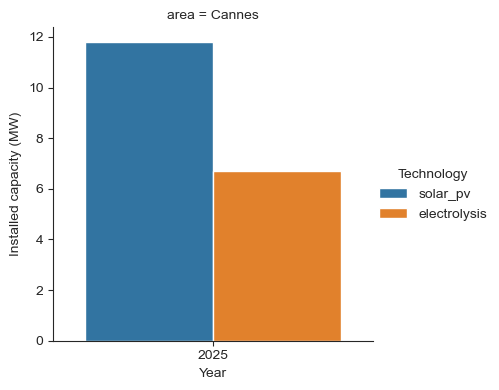

In [ ]:
capacities = case_1.get_results('operation', 'power_capacity', [ConversionTechnology])
capacities.pivot(on=['area', 'name'], values='value').with_columns(pl.selectors.all().round(2))

capacities = capacities.rename({
    "year_op": "Year",
    "value": "Installed capacity (MW)",
    "name": "Technology"
})
sns.catplot(
    data=capacities, x="Year", y="Installed capacity (MW)", hue='Technology', col="area",
    kind="bar", height=4, aspect=1.,
)
sns.despine()

We show also the H2 storage capacity in both LHV (MWh H2) and mass (tH2) units.

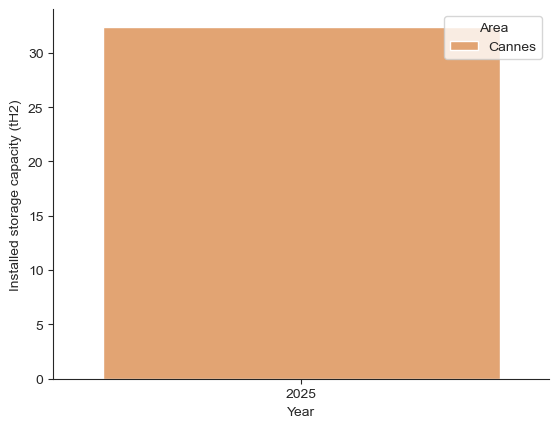

In [ ]:
storage_capacities = case_1.get_results('operation', 'energy_capacity', [StorageTechnology])
storage_capacities.drop('name').pivot(on=['area'], values='value').with_columns(pl.selectors.all().round(2))
storage_capacities = storage_capacities.with_columns(value=pl.col('value') / 33)

storage_capacities = storage_capacities.rename({
    "year_op": "Year",
    "value": "Installed storage capacity (tH2)",
    "name": "Technology",
    "area": "Area"
})

ax = sns.barplot(data=storage_capacities, x='Year', y='Installed storage capacity (tH2)', hue='Area',
                 palette=area_colors.values())
sns.despine()

#### Load factors
We can also check the load factors for different conversion technologies, as well as the storage level along the year. The load factor is defined as the instant power divided by the power capacity.

Text(0.5, 0, 'Year')

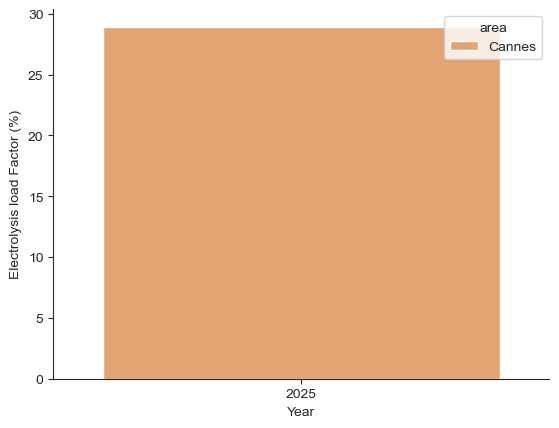

In [ ]:
capacities = case_1.get_results('operation', 'power_capacity', [ConversionTechnology]).rename(
    {'value': 'capacity'})
powers = case_1.get_results('operation', 'power', [ConversionTechnology])
avg_power = powers.group_by(['year_op', 'area', 'name']).agg(pl.col('value').mean()).rename({'value': 'avg_power'})
load_factors = (avg_power
                .join(capacities, on=['year_op', 'area', 'name'])
                .with_columns(load_factor=pl.col('avg_power') / pl.col('capacity') * 100.)
                .drop(['avg_power', 'capacity']))
load_factors.pivot(on=['area', 'name'], values='load_factor').with_columns(pl.selectors.all().round(2))

ax = sns.barplot(load_factors.filter(pl.col('name') == 'electrolysis'), x='year_op', y='load_factor', hue='area',
                 palette=area_colors.values())
sns.despine()
ax.set_ylabel('Electrolysis load Factor (%)')
ax.set_xlabel('Year')

#### Hydrogen costs
Finally, we analyse the project costs. We start by the share of each equipment in the (annualized) CAPEX. We can also check the share of different costs in the OPEX.

Text(0.5, 0, 'Year')

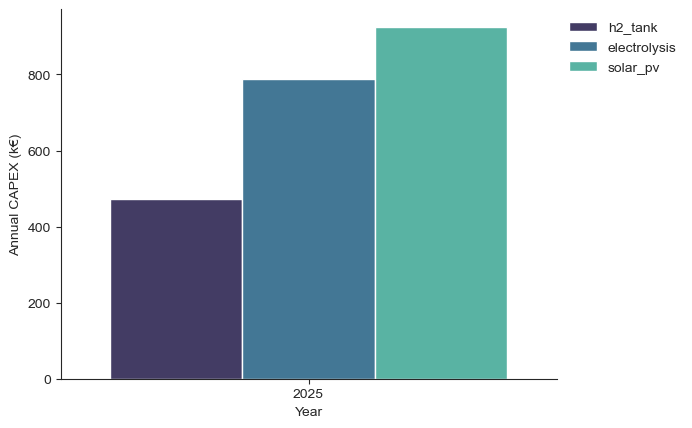

In [ ]:
capex = case_1.get_results('planning', 'costs').group_by(['year_op', 'name']).agg(pl.col('value').sum())
capex.pivot(on='name', values='value').with_columns(pl.selectors.all().round(0))

capex = capex.sort(by=['year_op', 'value']).with_columns(value=pl.col('value') * 1.e-3)
ax = sns.barplot(data=capex, x='year_op', y='value', hue='name', palette="mako")
sns.despine()
ax.legend(bbox_to_anchor=(1, 1), frameon=False)
ax.set_ylabel('Annual CAPEX (k€)')
ax.set_xlabel('Year')

Text(0.5, 0, 'Year')

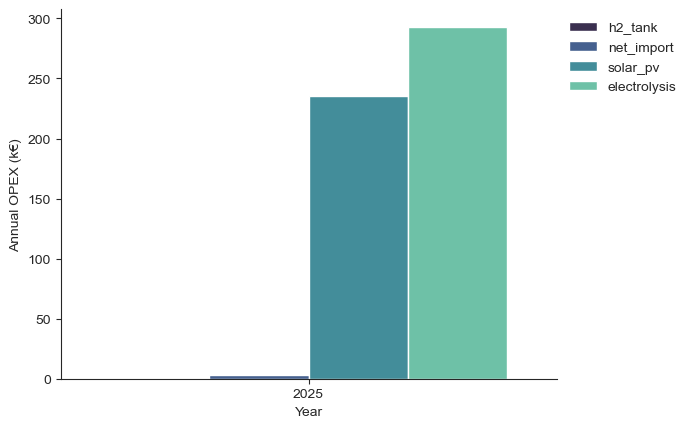

In [ ]:
opex = case_1.get_results('operation', 'costs').with_columns(
    name=pl.col("name").fill_null('net_import')).group_by(['year_op', 'name']).agg(pl.col('value').sum())
opex.pivot(on=['name'], values='value').with_columns(pl.selectors.all().round(0))

opex = opex.sort(by=['year_op', 'value']).with_columns(value=pl.col('value') * 1.e-3)
ax = sns.barplot(data=opex, x='year_op', y='value', hue='name', palette="mako")
sns.despine()
ax.legend(bbox_to_anchor=(1, 1), frameon=False)
ax.set_ylabel('Annual OPEX (k€)')
ax.set_xlabel('Year')

In [ ]:
totex = (capex
         .join(opex, on=['year_op','name'])
         .with_columns(totex=pl.col('value') + pl.col('value_right'))
         .group_by('year_op').sum())
totex = totex.rename({'value':'capex', 'value_right': 'opex'})

lcoh = economics.discount_rate.with_columns(h2_annual_prod = h2_demand_tons_per_day * 365)
lcoh.with_columns(discounted_annual_prod = pl.col('h2_annual_prod') * (1 - pl.col('discount_rate')) ** (pl.col('year_op') - 2025))

lcoh = lcoh.join(totex, on='year_op')
for value in ['h2_annual_prod','capex','opex','totex']:
  lcoh = lcoh.with_columns((pl.col(value) * (1 - pl.col('discount_rate')) ** (pl.col('year_op') - 2025)).alias('discounted_'+value))
lcoh = lcoh.select('discounted_totex').sum() / lcoh.select('discounted_h2_annual_prod').sum()


print(f'LCOH is {lcoh.item(0,0):.2f} EUR/kgH2')

LCOH is 9.30 EUR/kgH2


## Case 2
In this second case study, we suppose that the solar PV capacity will bee limited to both roof and parking surfaces in the bus deposit, corresponding to 4100 m<sup>2</sup> or 800 kWc. However, the electrolyzer can be also run on grid electricity. We are interested in determining the share of grid electricity used to feed the electrolyzer and in evaluating the cost of the hydrogen produced.

In [ ]:
def copy_case(old_case):
  new_case = deepcopy(old_case)
  new_areas = new_case.areas
  for component_index, component in enumerate(energy_model.components):
    for area_name, old_area in old_case.areas.items():
      if component in old_area.components.values():
        new_areas[area_name].components[component.name] = new_case.components[component_index]
  return new_case, new_areas

case_2, areas_case_2 = copy_case(energy_model)

#### Conversion Technologies
PV power capacity is limited to 800 kWc.

In [ ]:
case_2.areas, energy_model.areas

({'Cannes': <pommes_craft.components.area.Area at 0x5855f26f0>},
 {'Cannes': <pommes_craft.components.area.Area at 0x4c5c97140>})

In [ ]:
areas_case_2['Cannes'].components['solar_pv'].power_capacity_max=pl.DataFrame({'year_op':year_op,
                                                                        'power_capacity_max':0.8})


#### Network costs

We define network costs. Although in France those costs vary in time (find more info on TURPE here), here we consider only average constant costs of 5500 EUR/MW/year (fixed cost) and 18 EUR/MWh (variable cost).
For having only average constant costs, we set the calendar to base for all the time steps of the year.

In [ ]:
with case_2.context():
    turpe = Turpe(
        name='turpe',
        calendar='base',
        fixed_cost=5500.,
        variable_cost=18.
    )

#### Imports
In this case, we are able to use electricity form the grid. We must then set electricity prices at the hourly step at which electricity can be purchased. For this, we use French day-ahead electricity prices obtained from the [entsoe Transparency Platform](https://transparency.entsoe.eu), which contains open data for the European electricity markets. The figure below show those prices between 2019 and 2024. The prices change significantly between the 2020 lows (due to COVID-19 pandemics) and the 2022 energy crisis caused by the Russian invasion of Ukraine. We use 2023 price series as a reference scenario.  

In [972]:
# Read electricity prices from .csv files
electricity_prices = {
        year: pd.read_csv('./data/raw_data/Day-ahead Prices_entsoe_{:d}.csv'.format(year)) for year in (2019, 2020,2021, 2022,2023,2024)
    }

FileNotFoundError: [Errno 2] No such file or directory: './Cannes Lerins H2/data/raw_data//Day-ahead Prices_entsoe_2019.csv'

Text(0, 0.5, 'French electricity\nday-ahead prices (EUR/MWh)')

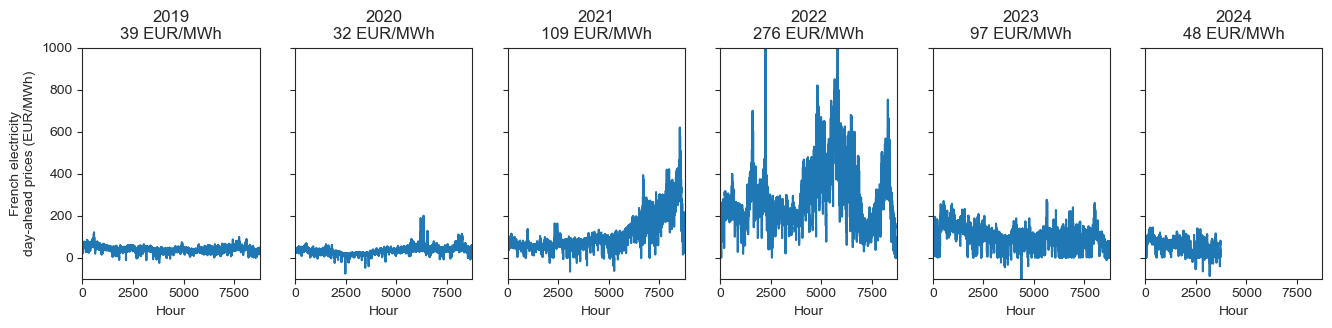

In [ ]:
# Plot prices time series for different years
fig, ax = plt.subplots(1, 6, figsize=(16,3), sharey=True)
for k, year in enumerate((2019, 2020, 2021, 2022,2023, 2024)):

    ax[k].plot(electricity_prices[year].index, electricity_prices[year]['Day-ahead Price [EUR/MWh]'])
    ax[k].set_title('{}\n{:.0f} EUR/MWh'.format(year,electricity_prices[year]['Day-ahead Price [EUR/MWh]'].mean()))

    ax[k].set_xlabel('Hour')
    ax[k].set_ylim([-100,1000])
    ax[k].set_xlim([0,8760])
ax[0].set_ylabel('French electricity\nday-ahead prices (EUR/MWh)')

In [ ]:
areas_case_2['Cannes'].components['electricity_import'].max_yearly_energy_import=pl.DataFrame({
    'year_op':year_op,
    'max_yearly_energy_import':1e12,
    'area': 'Cannes'
  })
areas_case_2['Cannes'].components['electricity_import'].max_yearly_energy_exmport=pl.DataFrame({
    'year_op':year_op,
    'max_yearly_energy_export':1e12,
    'area': 'Cannes'
  })
areas_case_2['Cannes'].components['electricity_import'].import_price = pl.DataFrame(
    data = {
    'import_price':[hours_step * np.mean(electricity_prices[2023].iloc[hour:hour+hours_step]['Day-ahead Price [EUR/MWh]']) for hour in hours],
    'hour':hours,
    'area': 'Cannes',}
    ).join(other=pl.DataFrame({'year_op':year_op}), how="cross")

In [ ]:
case_3, areas_case_3 = copy_case(case_2)

### Run model

In [ ]:
case_2.run()

Writing continuous variables.: 100%|██████████| 32/32 [00:00<00:00, 200.39it/s]


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-vhxavyxy has 192755 rows; 192743 cols; 538810 nonzeros
Coefficient ranges:
  Matrix [1e-03, 1e+05]
  Cost   [8e-01, 8e-01]
  Bound  [0e+00, 0e+00]
  RHS    [1e-03, 1e+12]
Presolving model
78841 rows, 70085 cols, 223433 nonzeros  0s
65754 rows, 56998 cols, 205913 nonzeros  0s
Dependent equations search running on 21953 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
65754 rows, 52671 cols, 197259 nonzeros  0s
Presolve : Reductions: rows 65754(-127001); columns 52671(-140072); elements 197259(-341551)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -7.3593798852e+00 Ph1: 41(186.75); Du: 20(7.35938) 0s
      18600     5.6481546299e+05 Pr: 17941(2.14652e+08) 6s
      23524     1.2706688905e+06 Pr: 19186(3.21161e+08) 11s

In [ ]:
case_2.set_all_results()

###  Results



In this section we analyse the obtained results and some key indicators.



#### Installed capacities

We start with the installed capacities for the different technologies. We start with electrolysis and solar PV capacities for each area.

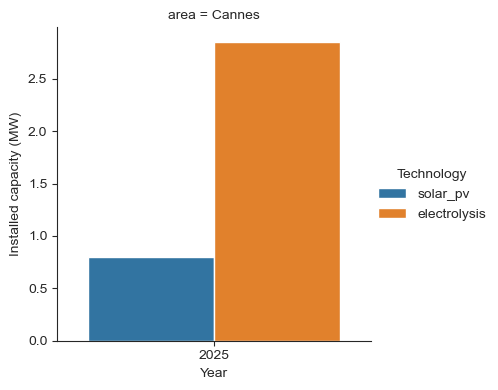

In [ ]:
capacities = case_2.get_results('operation', 'power_capacity', [ConversionTechnology])
capacities.pivot(on=['area', 'name'], values='value').with_columns(pl.selectors.all().round(2))

capacities = capacities.rename({
    "year_op": "Year",
    "value": "Installed capacity (MW)",
    "name": "Technology"
})
sns.catplot(
    data=capacities, x="Year", y="Installed capacity (MW)", hue='Technology', col="area",
    kind="bar", height=4, aspect=1.,
)
sns.despine()

We show also the H2 storage capacity in both LHV (MWh H2) and mass (tH2) units.

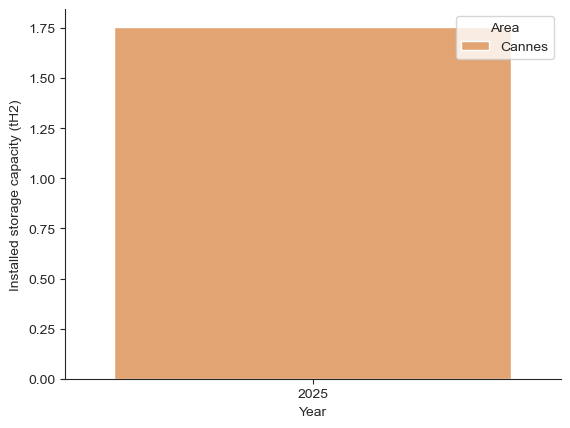

In [ ]:
storage_capacities = case_2.get_results('operation', 'energy_capacity', [StorageTechnology])
storage_capacities.drop('name').pivot(on=['area'], values='value').with_columns(pl.selectors.all().round(2))
storage_capacities = storage_capacities.with_columns(value=pl.col('value') / 33)

storage_capacities = storage_capacities.rename({
    "year_op": "Year",
    "value": "Installed storage capacity (tH2)",
    "name": "Technology",
    "area": "Area"
})

ax = sns.barplot(data=storage_capacities, x='Year', y='Installed storage capacity (tH2)', hue='Area',
                 palette=area_colors.values())
sns.despine()

#### Load factors
We can also check the load factors for different conversion technologies, as well as the storage level along the year. The load factor is defined as the instant power divided by the power capacity.

Text(0.5, 0, 'Year')

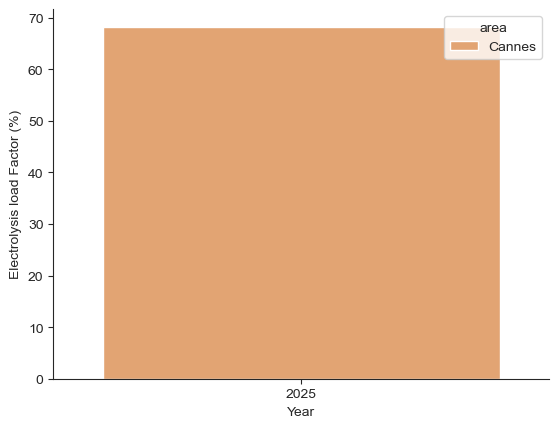

In [ ]:
capacities = case_2.get_results('operation', 'power_capacity', [ConversionTechnology]).rename(
    {'value': 'capacity'})
powers = case_2.get_results('operation', 'power', [ConversionTechnology])
avg_power = powers.group_by(['year_op', 'area', 'name']).agg(pl.col('value').mean()).rename({'value': 'avg_power'})
load_factors = (avg_power
                .join(capacities, on=['year_op', 'area', 'name'])
                .with_columns(load_factor=pl.col('avg_power') / pl.col('capacity') * 100.)
                .drop(['avg_power', 'capacity']))
load_factors.pivot(on=['area', 'name'], values='load_factor').with_columns(pl.selectors.all().round(2))

ax = sns.barplot(load_factors.filter(pl.col('name') == 'electrolysis'), x='year_op', y='load_factor', hue='area',
                 palette=area_colors.values())
sns.despine()
ax.set_ylabel('Electrolysis load Factor (%)')
ax.set_xlabel('Year')

#### Hydrogen costs
Finally, we analyse the project costs. We start by the share of each equipment in the (annualized) CAPEX. We can also check the share of different costs in the OPEX.

Text(0.5, 0, 'Year')

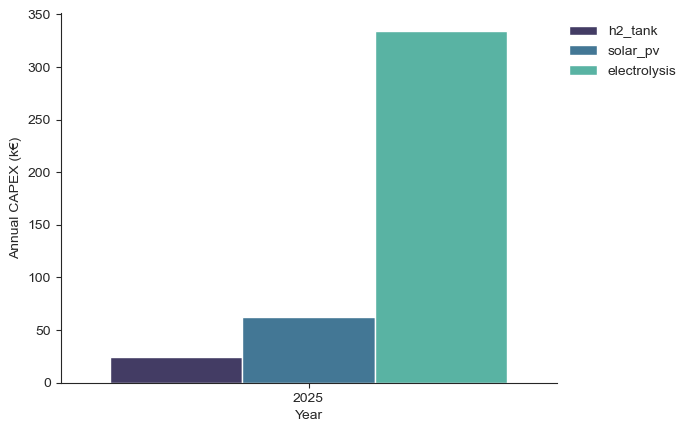

In [ ]:
capex = case_2.get_results('planning', 'costs').group_by(['year_op', 'name']).agg(pl.col('value').sum())
capex.pivot(on='name', values='value').with_columns(pl.selectors.all().round(0))

capex = capex.sort(by=['year_op', 'value']).with_columns(value=pl.col('value') * 1.e-3)
ax = sns.barplot(data=capex, x='year_op', y='value', hue='name', palette="mako")
sns.despine()
ax.legend(bbox_to_anchor=(1, 1), frameon=False)
ax.set_ylabel('Annual CAPEX (k€)')
ax.set_xlabel('Year')

Text(0.5, 0, 'Year')

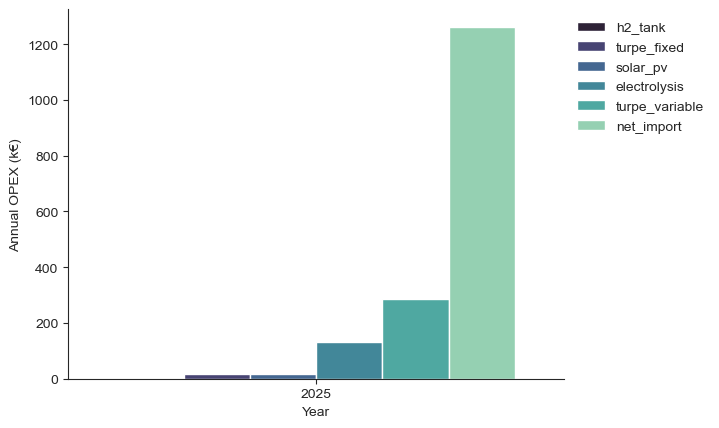

In [ ]:
opex = case_2.get_results('operation', 'costs').with_columns(
    name=pl.col("name").fill_null('net_import')).group_by(['year_op', 'name']).agg(pl.col('value').sum()).to_pandas()
opex.loc[opex['name'] == 'net_import', 'value' ] /= len(case_2.resources)
opex = pl.DataFrame(opex)
opex = case_2.get_results('operation','variable_costs').with_columns(name=pl.Series(['turpe_variable'])).drop('area').update(opex, on=['year_op','name'], how='full')
opex = case_2.get_results('operation','fixed_costs').with_columns(name=pl.Series(['turpe_fixed'])).drop('area').update(opex, on=['year_op','name'], how='full')

opex.pivot(on=['name'], values='value').with_columns(pl.selectors.all().round(0))
opex.with_columns
opex = opex.sort(by=['year_op', 'value']).with_columns(value=pl.col('value') * 1.e-3)
ax = sns.barplot(data=opex, x='year_op', y='value', hue='name', palette="mako")
sns.despine()
ax.legend(bbox_to_anchor=(1, 1), frameon=False)
ax.set_ylabel('Annual OPEX (k€)')
ax.set_xlabel('Year')

In [ ]:
sol2 = case_2.linopy_model.solution
electricity_cost = sol2['operation_net_import_costs'].loc[{'area': 'Cannes', 'resource':'electricity'}] + (sol2['operation_turpe_fixed_costs'] + sol2['operation_turpe_variable_costs']).loc[{'area': 'Cannes'}] 
electricity_imports = sol2['operation_net_import_import'].loc[{'area': 'Cannes', 'resource':'electricity'}].sum('hour')
mean_electricity_price = electricity_cost/electricity_imports
print("Mean imported electricity price : {:.1f} EUR/MWh".format(mean_electricity_price.values[0]))

Mean imported electricity price : 98.3 EUR/MWh


In [ ]:
totex = (opex
         .join(capex, on=['year_op','name'], 
               how='left').group_by('year_op').sum()
         .with_columns(totex=pl.col('value') + pl.col('value_right')))

totex = totex.rename({'value':'opex', 'value_right': 'capex'})

lcoh = economics.discount_rate.with_columns(h2_annual_prod = h2_demand_tons_per_day * 365)
lcoh.with_columns(discounted_annual_prod = pl.col('h2_annual_prod') * (1 - pl.col('discount_rate')) ** (pl.col('year_op') - 2025))

lcoh = lcoh.join(totex, on='year_op')
for value in ['h2_annual_prod','capex','opex','totex']:
  lcoh = lcoh.with_columns((pl.col(value) * (1 - pl.col('discount_rate')) ** (pl.col('year_op') - 2025)).alias('discounted_'+value))

lcoh = lcoh.select('discounted_totex').sum() / lcoh.select('discounted_h2_annual_prod').sum()


print(f'LCOH is {lcoh.item(0,0):.3f} EUR/kgH2')

LCOH is 7.305 EUR/kgH2


#### Operation

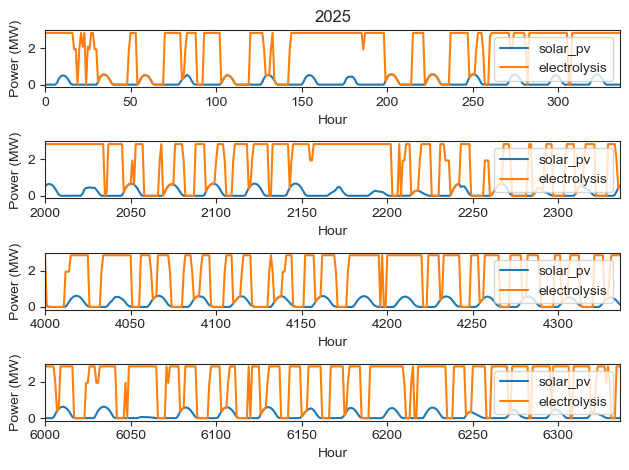

In [ ]:
conversion_tech_electric_power = (case_2.get_results('operation', 'power')
    .rename({'name': 'tech', 'value': 'power'})
    .filter(
        pl.col('area')=='Cannes', 
    ).select('hour', 'power', 'tech', 'year_op')
    .rename({
                       'power': 'Power (MW)', 
                       'year_op': 'Year', 
                       'hour': 'Hour'
                    })
)

week_hours = [0, 2000, 4000, 6000]

for i, year in enumerate(year_op):
    fig, ax = plt.subplots(len(week_hours), 1, sharey=True, squeeze=False)
    for j, start_hour in enumerate(week_hours): 
        ax[0,0].set_title(year)
        sns.lineplot(data=conversion_tech_electric_power.filter(pl.col('Year')==year), x='Hour', y='Power (MW)', hue='tech', ax=ax[j,0])
        ax[j,0].set_xlim([start_hour,start_hour + 14* 24])
        ax[j,0].legend(loc='upper right') 
    fig.tight_layout()

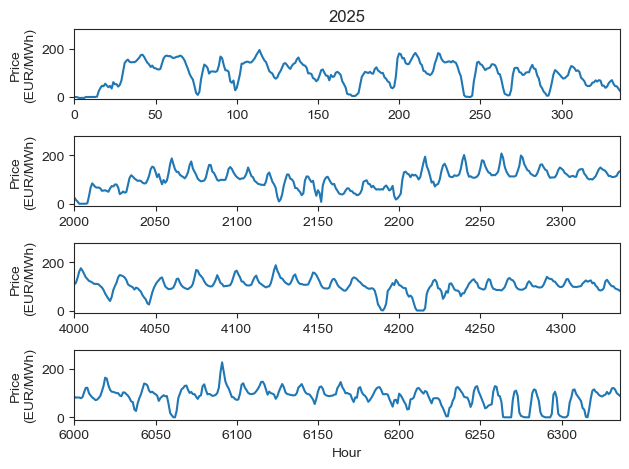

In [ ]:


fig, ax = plt.subplots(len(week_hours), 1, sharey=True, squeeze=False)
for j, start_hour in enumerate(week_hours): 
    ax[0,0].set_title(year)
    sns.lineplot(x=np.arange(8761),y=electricity_prices[2023]['Day-ahead Price [EUR/MWh]'], ax=ax[j,0])
    ax[j,0].set_xlim([start_hour,start_hour + 14* 24])
    ax[j,0].set_ylabel('Price\n(EUR/MWh)')
    ax[j,0].set_ylim(-10,280)
    ax[-1,0].set_xlabel('Hour')
    fig.tight_layout()

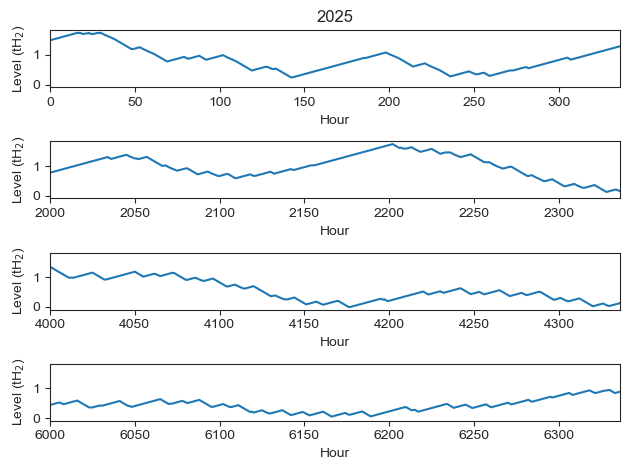

In [ ]:
h2_tank_storage = (areas_case_2['Cannes'].components['h2_tank']
                   .results['operation']['level']
                   .with_columns(level_tH2 = pl.col('value') / LHV_H2)
                   .rename({
                       'level_tH2': 'Level (tH$_2$)', 
                       'year_op': 'Year', 
                       'hour': 'Hour'
                    })
)

for i, year in enumerate(year_op):
    fig, ax = plt.subplots(len(week_hours), 1, sharey=True, squeeze=False)
    for j, start_hour in enumerate(week_hours): 
        ax[0,0].set_title(year)
        sns.lineplot(h2_tank_storage.filter(pl.col('Year')==year), x='Hour', y='Level (tH$_2$)', ax=ax[j,0])
        ax[j,0].set_xlim([start_hour,start_hour + 14* 24])
    fig.tight_layout()



## Case study 3
In this third case study, we suppose that the solar PV capacity will bee limited to both roof and parking surfaces in the bus deposit, corresponding to 4100 m<sup>2</sup> or 800 kWc, and that the electrolyzer can be also run on grid electricity, as in case 2. However, we limit hydrogen storage capacity to 1 ton, to account for regulatory constraints. 


In [ ]:
areas_case_3['Cannes'].components['h2_tank'].energy_capacity_investment_max=pl.DataFrame({'year_op':year_op,
                                                                        "energy_capacity_investment_max":LHV_H2})


### Run model

In [ ]:
case_3.run()

Writing continuous variables.: 100%|██████████| 32/32 [00:00<00:00, 192.28it/s]


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-_byketfn has 192755 rows; 192743 cols; 538810 nonzeros
Coefficient ranges:
  Matrix [1e-03, 1e+05]
  Cost   [8e-01, 8e-01]
  Bound  [0e+00, 0e+00]
  RHS    [1e-03, 1e+12]
Presolving model
78841 rows, 70085 cols, 223433 nonzeros  0s
65754 rows, 56998 cols, 205913 nonzeros  0s
Dependent equations search running on 21953 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
65754 rows, 52671 cols, 197259 nonzeros  0s
Presolve : Reductions: rows 65754(-127001); columns 52671(-140072); elements 197259(-341551)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -7.3593798852e+00 Ph1: 41(186.75); Du: 20(7.35938) 0s
      18600     5.6481546299e+05 Pr: 17941(2.14652e+08) 6s
      23524     1.2706688905e+06 Pr: 19186(3.21161e+08) 11s

In [ ]:
case_3.set_all_results()

###  Results



In this section we analyse the obtained results and some key indicators.



#### Installed capacities

We start with the installed capacities for the different technologies. We start with electrolysis and solar PV capacities for each area.

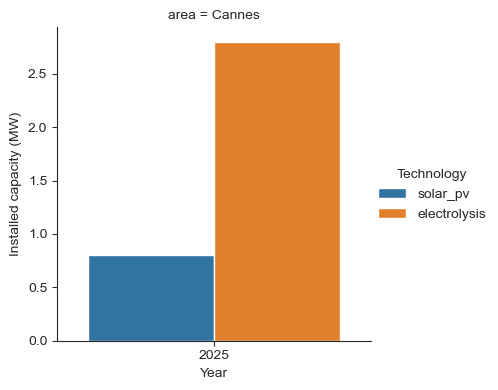

In [ ]:
capacities = case_3.get_results('operation', 'power_capacity', [ConversionTechnology])
capacities.pivot(on=['area', 'name'], values='value').with_columns(pl.selectors.all().round(2))

capacities = capacities.rename({
    "year_op": "Year",
    "value": "Installed capacity (MW)",
    "name": "Technology"
})
sns.catplot(
    data=capacities, x="Year", y="Installed capacity (MW)", hue='Technology', col="area",
    kind="bar", height=4, aspect=1.,
)
sns.despine()

We show also the H2 storage capacity in both LHV (MWh H2) and mass (tH2) units.

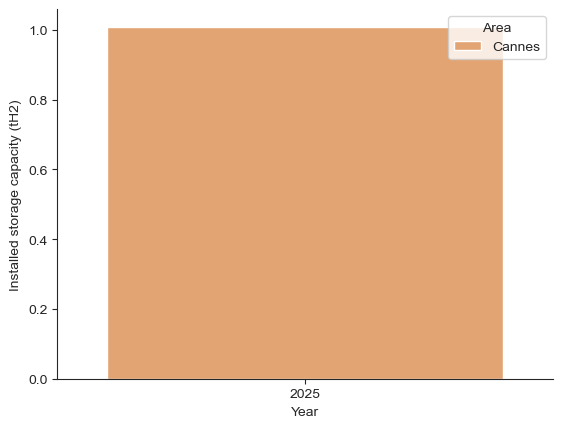

In [ ]:
storage_capacities = case_3.get_results('operation', 'energy_capacity', [StorageTechnology])
storage_capacities.drop('name').pivot(on=['area'], values='value').with_columns(pl.selectors.all().round(2))
storage_capacities = storage_capacities.with_columns(value=pl.col('value') / 33)

storage_capacities = storage_capacities.rename({
    "year_op": "Year",
    "value": "Installed storage capacity (tH2)",
    "name": "Technology",
    "area": "Area"
})

ax = sns.barplot(data=storage_capacities, x='Year', y='Installed storage capacity (tH2)', hue='Area',
                 palette=area_colors.values())
sns.despine()

#### Load factors
We can also check the load factors for different conversion technologies, as well as the storage level along the year. The load factor is defined as the instant power divided by the power capacity.

Text(0.5, 0, 'Year')

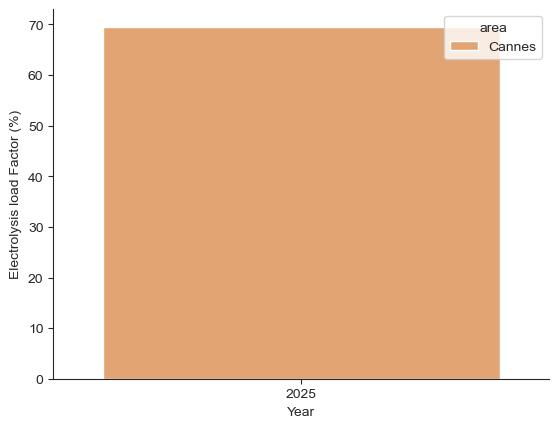

In [ ]:
capacities = case_3.get_results('operation', 'power_capacity', [ConversionTechnology]).rename(
    {'value': 'capacity'})
powers = case_3.get_results('operation', 'power', [ConversionTechnology])
avg_power = powers.group_by(['year_op', 'area', 'name']).agg(pl.col('value').mean()).rename({'value': 'avg_power'})
load_factors = (avg_power
                .join(capacities, on=['year_op', 'area', 'name'])
                .with_columns(load_factor=pl.col('avg_power') / pl.col('capacity') * 100.)
                .drop(['avg_power', 'capacity']))
load_factors.pivot(on=['area', 'name'], values='load_factor').with_columns(pl.selectors.all().round(2))

ax = sns.barplot(load_factors.filter(pl.col('name') == 'electrolysis'), x='year_op', y='load_factor', hue='area',
                 palette=area_colors.values())
sns.despine()
ax.set_ylabel('Electrolysis load Factor (%)')
ax.set_xlabel('Year')

#### Hydrogen costs
Finally, we analyse the project costs. We start by the share of each equipment in the (annualized) CAPEX. We can also check the share of different costs in the OPEX.

Text(0.5, 0, 'Year')

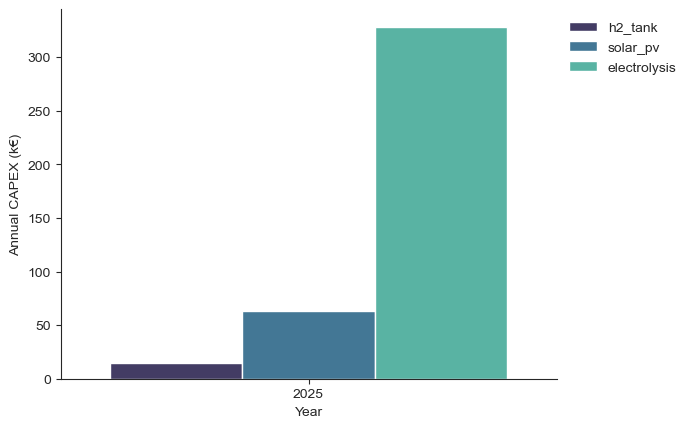

In [ ]:
capex = case_3.get_results('planning', 'costs').group_by(['year_op', 'name']).agg(pl.col('value').sum())
capex.pivot(on='name', values='value').with_columns(pl.selectors.all().round(0))

capex = capex.sort(by=['year_op', 'value']).with_columns(value=pl.col('value') * 1.e-3)
ax = sns.barplot(data=capex, x='year_op', y='value', hue='name', palette="mako")
sns.despine()
ax.legend(bbox_to_anchor=(1, 1), frameon=False)
ax.set_ylabel('Annual CAPEX (k€)')
ax.set_xlabel('Year')

Text(0.5, 0, 'Year')

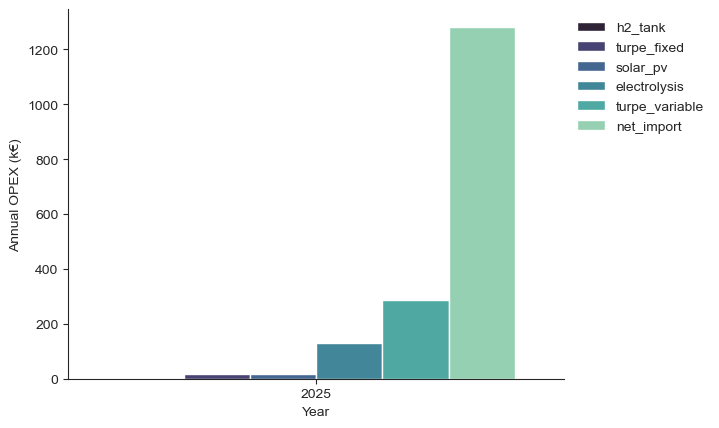

In [ ]:
opex = case_3.get_results('operation', 'costs').with_columns(
    name=pl.col("name").fill_null('net_import')).group_by(['year_op', 'name']).agg(pl.col('value').sum()).to_pandas()
opex.loc[opex['name'] == 'net_import', 'value' ] /= len(case_2.resources)
opex = pl.DataFrame(opex)
opex = case_3.get_results('operation','variable_costs').with_columns(name=pl.Series(['turpe_variable'])).drop('area').update(opex, on=['year_op','name'], how='full')
opex = case_3.get_results('operation','fixed_costs').with_columns(name=pl.Series(['turpe_fixed'])).drop('area').update(opex, on=['year_op','name'], how='full')

opex.pivot(on=['name'], values='value').with_columns(pl.selectors.all().round(0))
opex.with_columns
opex = opex.sort(by=['year_op', 'value']).with_columns(value=pl.col('value') * 1.e-3)
ax = sns.barplot(data=opex, x='year_op', y='value', hue='name', palette="mako")
sns.despine()
ax.legend(bbox_to_anchor=(1, 1), frameon=False)
ax.set_ylabel('Annual OPEX (k€)')
ax.set_xlabel('Year')

In [ ]:
totex = (opex
         .join(capex, on=['year_op','name'], 
               how='left').group_by('year_op').sum()
         .with_columns(totex=pl.col('value') + pl.col('value_right')))

totex = totex.rename({'value':'opex', 'value_right': 'capex'})

lcoh = economics.discount_rate.with_columns(h2_annual_prod = h2_demand_tons_per_day * 365)
lcoh.with_columns(discounted_annual_prod = pl.col('h2_annual_prod') * (1 - pl.col('discount_rate')) ** (pl.col('year_op') - 2025))

lcoh = lcoh.join(totex, on='year_op')
for value in ['h2_annual_prod','capex','opex','totex']:
  lcoh = lcoh.with_columns((pl.col(value) * (1 - pl.col('discount_rate')) ** (pl.col('year_op') - 2025)).alias('discounted_'+value))

lcoh = lcoh.select('discounted_totex').sum() / lcoh.select('discounted_h2_annual_prod').sum()


print(f'LCOH is {lcoh.item(0,0):.3f} EUR/kgH2')

LCOH is 7.312 EUR/kgH2


In [ ]:
sol3 = case_3.linopy_model.solution
electricity_cost = sol3['operation_net_import_costs'].loc[{'area': 'Cannes', 'resource':'electricity'}] + (sol3['operation_turpe_fixed_costs'] + sol3['operation_turpe_variable_costs']).loc[{'area': 'Cannes'}] 
electricity_imports = sol3['operation_net_import_import'].loc[{'area': 'Cannes', 'resource':'electricity'}].sum('hour')
mean_electricity_price = electricity_cost/electricity_imports
print("Mean imported electricity price : {:.1f} EUR/MWh".format(mean_electricity_price.values[0]))

Mean imported electricity price : 99.6 EUR/MWh


#### Operation

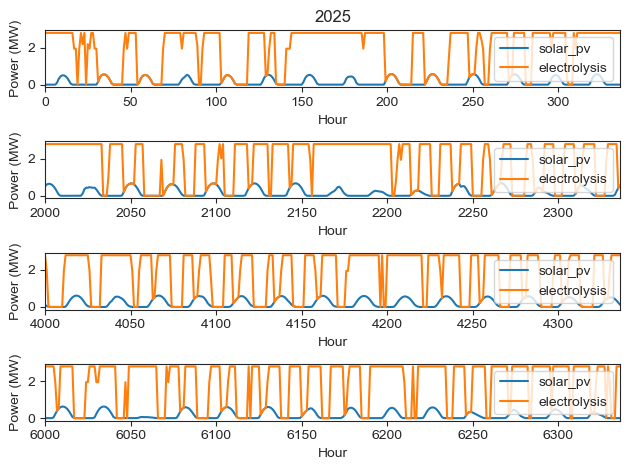

In [ ]:
conversion_tech_electric_power = (case_3.get_results('operation', 'power')
    .rename({'name': 'tech', 'value': 'power'})
    .filter(
        pl.col('area')=='Cannes', 
    ).select('hour', 'power', 'tech', 'year_op')
    .rename({
                       'power': 'Power (MW)', 
                       'year_op': 'Year', 
                       'hour': 'Hour'
                    })
)

week_hours = [0, 2000, 4000, 6000]

for i, year in enumerate(year_op):
    fig, ax = plt.subplots(len(week_hours), 1, sharey=True, squeeze=False)
    for j, start_hour in enumerate(week_hours): 
        ax[0,0].set_title(year)
        sns.lineplot(data=conversion_tech_electric_power.filter(pl.col('Year')==year), x='Hour', y='Power (MW)', hue='tech', ax=ax[j,0])
        ax[j,0].set_xlim([start_hour,start_hour + 14* 24])
        ax[j,0].legend(loc='upper right') 
    fig.tight_layout()

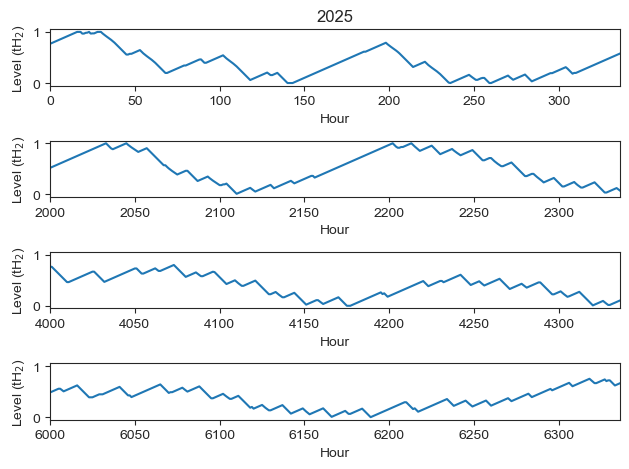

In [ ]:
h2_tank_storage = (areas_case_3['Cannes'].components['h2_tank']
                   .results['operation']['level']
                   .with_columns(level_tH2 = pl.col('value') / LHV_H2)
                   .rename({
                       'level_tH2': 'Level (tH$_2$)', 
                       'year_op': 'Year', 
                       'hour': 'Hour'
                    })
)

for i, year in enumerate(year_op):
    fig, ax = plt.subplots(len(week_hours), 1, sharey=True, squeeze=False)
    for j, start_hour in enumerate(week_hours): 
        ax[0,0].set_title(year)
        sns.lineplot(h2_tank_storage.filter(pl.col('Year')==year), x='Hour', y='Level (tH$_2$)', ax=ax[j,0])
        ax[j,0].set_xlim([start_hour,start_hour + 14* 24])
    fig.tight_layout()

